In [143]:
import torch
import numpy as np
import torch.nn as nn
from torch.autograd import Variable
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms


A Pix2Pix GAN, short for "Image-to-Image Generative Adversarial Network," is a type of generative model used in computer vision and image processing. Pix2Pix is designed to transform one type of image into another, where both the input and output images are paired and share a direct relationship.

#1- Download Dataset(2 p)
download dataset from this link and extract it:
http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/maps.tar.gz

In [144]:
# -----------------------------------------------------
# Downaload dataset from above link with !wget
# Extract it with 
# -----------------------------------------------------
############### Complete this part ##############(2 points)
!wget http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/maps.tar.gz --continue
!tar -xvf maps.tar.gz

--2023-02-03 17:07:39--  http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/maps.tar.gz
Resolving efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)... 128.32.244.190
Connecting to efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)|128.32.244.190|:80... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

maps/
maps/train/
maps/train/1.jpg
maps/train/10.jpg
maps/train/100.jpg
maps/train/1000.jpg
maps/train/1001.jpg
maps/train/1002.jpg
maps/train/1003.jpg
maps/train/1004.jpg
maps/train/1005.jpg
maps/train/1006.jpg
maps/train/1007.jpg
maps/train/1008.jpg
maps/train/1009.jpg
maps/train/101.jpg
maps/train/1010.jpg
maps/train/1011.jpg
maps/train/1012.jpg
maps/train/1013.jpg
maps/train/1014.jpg
maps/train/1015.jpg
maps/train/530.jpg
maps/train/531.jpg
maps/train/532.jpg
maps/train/533.jpg
maps/train/534.jpg
maps/train/535.jpg
maps/train/536.jpg
maps/train/537.jpg
maps/train/538.jpg
maps

#2- Dataset Class(3 p)

In [145]:
class Maps_Dataset(Dataset):
    def __init__(self, ImagesDirectory):
        self.ImagesDirectory = ImagesDirectory
        self.files = os.listdir(self.ImagesDirectory)
        self.transforms = transforms.Compose([  transforms.Resize((256, 256), Image.BICUBIC),
                                                transforms.ToTensor(),
                                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),])

    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
        # reading one image from dataset
        img_name = self.files[index]
        img_path = os.path.join(self.ImagesDirectory, img_name)
        img = np.array(Image.open(img_path))
        # -----------------------------------------------------
        # split image into two part IMAGE and MAP (see one sample of dataset)
        # apply self.transforms to IMAGE and MAP to Normalize and Resize the images
        # -----------------------------------------------------
        ############### Complete this part ############### (3 points)
        input_image = img[:, :600, :]
        target_image = img[:, 600:, :]

        IMAGE = self.transforms(Image.fromarray(input_image.astype('uint8'), 'RGB'))
        MAP = self.transforms(Image.fromarray(target_image.astype('uint8'), 'RGB'))

        return {"IMAGE": IMAGE, "MAP": MAP}

#3-Create Generator with the help of the Block module and test it(32 p)

In [146]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, act="relu", use_dropout=False):
        super(Block, self).__init__()

        # Select appropriate convolutional or transpose convolutional layer
        if down:
            self.conv = nn.Conv2d(in_channels, out_channels, 4, 2, 1, bias=False, padding_mode="reflect")
        else:
            self.conv = nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1, bias=False)
        
        # Initialize batch normalization and activation layers
        self.bn = nn.BatchNorm2d(out_channels)
        self.act = nn.ReLU() if act == "relu" else nn.LeakyReLU(0.2)

        # Flag for using dropout
        self.use_dropout = use_dropout
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Apply convolutional layer
        x = self.conv(x)

        # Apply batch normalization and activation
        x = self.bn(x)
        x = self.act(x)

        # Apply dropout if specified
        if self.use_dropout:
            x = self.dropout(x)

        return x

class Generator(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()


        # -----------------------------------------------------
        # based on aritcle appendix define Encoder( page 16)
        # C64-C128-C256-C512-C512-C512-C512-C512
        # -----------------------------------------------------
        ############### Complete this part ############### (10 points)
        self.initial_down = nn.Sequential(
            nn.Conv2d(in_channels, 64 , 4, 2, 1, padding_mode="reflect"),
            nn.LeakyReLU(0.2),
        ) # C3 => C64
        self.encoder1 =  Block(64, 128, down=True, act="leaky", use_dropout=False)
        self.encoder2 = Block(128, 256, down=True, act="leaky", use_dropout=False)
        self.encoder3 = Block(256, 512, down=True, act="leaky", use_dropout=False)
        self.encoder4 = Block(512, 512, down=True, act="leaky", use_dropout=False)
        self.encoder5 = Block(512, 512, down=True, act="leaky", use_dropout=False)
        self.encoder6 = Block(512, 512, down=True, act="leaky", use_dropout=False)
        self.encoder7 = Block(512, 512, down=True, act="leaky", use_dropout=False)

        self.bottleneck = nn.Sequential(
            nn.Conv2d(512 , 512 , 4, 2, 1), nn.ReLU()
        )
        # -----------------------------------------------------
        # based on aritcle appendix define Decoder ( page 16)
        # CD512-CD512-CD512-C512-C256-C128-C64
        # -----------------------------------------------------
        ############### Complete this part ############### (10 points)
        self.decoder1 = Block(512, 512, down=False, act="relu", use_dropout=True)
        self.decoder2 = Block(1024, 512, down=False, act="relu", use_dropout=True)
        self.decoder3 = Block(1024, 512, down=False, act="relu", use_dropout=True)
        self.decoder4 = Block(1024, 512, down=False, act="relu", use_dropout=False)
        self.decoder5 = Block(1024, 256, down=False, act="relu", use_dropout=False)
        self.decoder6 = Block(512, 128, down=False, act="relu", use_dropout=False)
        self.decoder7 = Block(256, 64, down=False, act="relu", use_dropout=False)

        self.final_up = nn.Sequential(
            nn.ConvTranspose2d(128, in_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        # -----------------------------------------------------
        # create network like U-Net
        # -----------------------------------------------------
        ############### Complete this part ############### (10 points)

        d1 = self.initial_down(x)
        d2 = self.encoder1(d1)
        d3 = self.encoder2(d2)
        d4 = self.encoder3(d3)
        d5 = self.encoder4(d4)
        d6 = self.encoder5(d5)
        d7 = self.encoder6(d6)
        bottleneck = self.bottleneck(d7)
        up1 = self.decoder1(bottleneck)
        up2 = self.decoder2(torch.cat([up1, d7], 1))
        up3 = self.decoder3(torch.cat([up2, d6], 1))
        up4 = self.decoder4(torch.cat([up3, d5], 1))
        up5 = self.decoder5(torch.cat([up4, d4], 1))
        up6 = self.decoder6(torch.cat([up5, d3], 1))
        up7 = self.decoder7(torch.cat([up6, d2], 1))
        out = self.final_up(torch.cat([up7, d1], 1))
        return out

In [147]:
def test():
    # -----------------------------------------------------
    #  test generator : output should be (B,C,256,256)
    # -----------------------------------------------------
    ############### Complete this part ############### (2 points)
    # test the model
    generator = Generator()
    generator.eval()
    noise = torch.randn((1, 3, 256, 256))
    generated_image = generator(noise)
    return generated_image.shape

test()

torch.Size([1, 3, 256, 256])


#4-Discriminator, Just test it (3 p)
This code defines a discriminator network for a patch GAN. The network takes in two images of size 256x256 and concatenates them along the channel dimension. It then passes the concatenated image through a series of convolutional layers, batch normalization layers, and activation layers. The final layer is a convolutional layer with a single channel output image of size 32x32 each number shows the probability of being fake for a patch of the input image

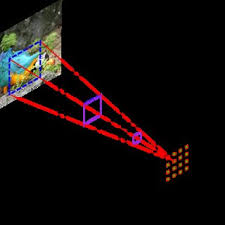

In [148]:

class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64, 128, 256, 512]):
        super().__init__()
        # Initial convolutional layer with stride 2
        self.initial = nn.Sequential(
            nn.Conv2d(
                in_channels * 2,  # Number of input channels is doubled because of concatenation
                features[0],  # Number of output channels
                kernel_size=4,  # Kernel size
                stride=2,  # Stride of 2 halves the size of the image
                padding=1,  # Padding to maintain spatial dimensions
                padding_mode="reflect",  # Reflect padding pads the input with a reflection of itself
            ),
            nn.LeakyReLU(0.2),  # Activation function
        )

        # Sequential layer with multiple convolutional and normalization layers
        layers = []
        in_channels = features[0]  # Number of input channels for the first layer
        for feature in features[1:]:
            layers.append(
                nn.Sequential(
                    nn.Conv2d(
                        in_channels,  # Number of input channels
                        feature,  # Number of output channels
                        kernel_size=4,  # Kernel size
                        stride=1 if feature == features[-1] else 2,  # Stride of 1 for the last layer, otherwise 2
                        padding=1,  # Padding to maintain spatial dimensions
                        padding_mode="reflect",  # Reflect padding pads the input with a reflection of itself
                    ),
                    nn.BatchNorm2d(feature),  # Batch normalization layer
                    nn.LeakyReLU(0.2),  # Activation function
                )
            )
            in_channels = feature  # Update the number of input channels for the next layer

        # Final convolutional layer with single channel output
        layers.append(
            nn.Conv2d(
                in_channels,  # Number of input channels
                1,  # Number of output channels
                kernel_size=4,  # Kernel size
                stride=1,  # Stride of 1 maintains the size of the image
                padding=2,  # Padding to maintain spatial dimensions
                padding_mode="reflect",  # Reflect padding pads the input with a reflection of itself
            ),
        )

        # Stack the layers into a single model
        self.model = nn.Sequential(*layers)

    def forward(self, x, y):
        # Concatenate the two input images along the channel dimension
        x = torch.cat([x, y], dim=1)
        # Pass the concatenated image through the initial convolutional layer
        x = self.initial(x)
        # Pass the output through the rest of the layers
        x = self.model(x)
        # Return the output
        return x

In [149]:
def test_discriminator():
        # -----------------------------------------------------
        #  test discriminator : output should be (B,1,32,32)
        # -----------------------------------------------------
        ############### Complete this part ############### (3 points)
    x = torch.randn((1, 3, 256, 256))
    y = torch.randn((1, 3, 256, 256))
    model = Discriminator(in_channels=3)
    preds = model(x, y)
    return preds.shape

test_discriminator()

torch.Size([1, 1, 32, 32])


#5-define hyperparameters and useful functions

In [150]:
DATA_SET_TRAIN = "/content/maps/train"
DATA_SET_VAL = "/content/maps/val"
BATCH_SIZE = 1
LR = 0.0002
B1 = 0.5
B2 = 0.999
IMG_HEIGHT = 256
IMG_WIDTH =  256

# This function initializes the weights of a neural network model in PyTorch. It takes a single argument, m, which is a module (e.g., a layer) in the model.
# This function is often used as a weights_init function when defining a PyTorch model, which can then be applied to the model using the apply method:
# model = MyModel()
# model.apply(weights_init_normal)

def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

#6-training(50 p)

In [151]:
!mkdir generated_maps
# Check if GPU is available and store the result in 'cuda'
cuda = torch.cuda.is_available()

# GAN loss function using mean squared error
criterion_GAN = torch.nn.MSELoss()

# Pixel-wise loss function using mean absolute error
criterion_pixelwise = torch.nn.L1Loss()

# Weight for pixel-wise loss in total loss
lambda_pixel = 100

# Initialize generator and discriminator networks
generator = Generator()
discriminator = Discriminator()

# Initialize network weights using normal distribution
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

# If GPU is available, move the networks and loss functions to the GPU
if cuda:
    generator = generator.cuda()
    discriminator = discriminator.cuda()
    criterion_GAN.cuda()
    criterion_pixelwise.cuda()

# Adam optimizers for generator and discriminator
optimizer_G = torch.optim.Adam(generator.parameters(), lr=LR, betas=(B1, B2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=LR, betas=(B1, B2))

# DataLoader for training data
dataloader = DataLoader(Maps_Dataset(DATA_SET_TRAIN), batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

# DataLoader for validation data
val_dataloader = DataLoader(Maps_Dataset(DATA_SET_VAL), batch_size=4, shuffle=True, num_workers=2)

# Tensor type for GPU or CPU
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

EPOCH = 100
# Training loop
for epoch in range(EPOCH):
    itt = 0
    total_d = 0
    total_g = 0
    for i, batch in enumerate(dataloader):

        
        # Get model inputs
        IMG_REAL = Variable(batch["IMAGE"].type(Tensor))
        MAP_REAL = Variable(batch["MAP"].type(Tensor))

        # Adversarial ground truths
        patcc_gan_output = (1, 32,32)
        REAL = Variable(Tensor(np.ones((IMG_REAL.size(0), *patcc_gan_output))), requires_grad=False)
        FAKE = Variable(Tensor(np.zeros((IMG_REAL.size(0), *patcc_gan_output))), requires_grad=False)

        # -------------------------------------------------------
        #  Train Generator
        # -------------------------------------------------------
        optimizer_G.zero_grad()
        # Generate fake maps
        MAP_FAKE = generator(IMG_REAL)
        # Loss for generator
        loss_GAN = criterion_GAN(discriminator(MAP_FAKE, IMG_REAL), REAL)
        loss_pixel = criterion_pixelwise(MAP_FAKE, MAP_REAL)
        loss_G = loss_GAN + lambda_pixel * loss_pixel
        # Update gradients and optimize
        loss_G.backward()
        optimizer_G.step()
        # ------------------------------------------------------
        #  Train Discriminator
        # ------------------------------------------------------
        optimizer_D.zero_grad()
        # Loss for real images
        loss_D_real = criterion_GAN(discriminator(MAP_REAL, IMG_REAL), REAL)      
        # Loss for fake images
        loss_D_fake = criterion_GAN(discriminator(MAP_FAKE.detach(), IMG_REAL), FAKE)    
        # Total loss for discriminator
        loss_D = 0.5 * (loss_D_real + loss_D_fake)
        # Update gradients and optimize
        loss_D.backward()
        optimizer_D.step()
        itt += 1
        total_g += loss_G.item()
        total_d += loss_D.item()
        Iteration = epoch * len(dataloader) + i
        # -----------------------------------------------------
        #  every 500 iterations: print logs you need 
        # -----------------------------------------------------
        if (Iteration % 500 == 0):
            print("Epoch [{}/{}], Step [{}/{}], Loss_D: {:.4f}, Loss_G: {:.4f}".format(epoch+1, EPOCH, i+1, len(dataloader), total_d/itt, total_g/itt))

        #------------------------------------------------------
        # every 500 iterations: give one batch of val data(4 images) to generator and save results in .png or .jpg
        #------------------------------------------------------

        if Iteration % 500 == 0:
            val_batch = next(iter(val_dataloader))
            IMG_REAL_val = Variable(val_batch["IMAGE"].type(Tensor))
            MAP_REAL_val = Variable(val_batch["MAP"].type(Tensor))
            
            # Generate maps using validation images
            MAP_FAKE_val = generator(IMG_REAL_val)
            
            # Save generated maps as images
            for j in range(4):
                im1 = IMG_REAL_val[j, :, :, :]
                im2 = MAP_FAKE_val[j, :, :, :]
                im3 = MAP_REAL_val[j, :, :, :]
                arrr = torch.cat((im1, im2, im3), -2)
                arrr = ((np.moveaxis(np.squeeze(arrr.cpu().detach().numpy()), 0, 2) *0.5 + 0.5 ) * 255 ).astype('uint8')
                im = Image.fromarray(arrr)
                im.save(f"generated_maps/map_iteration_{Iteration}_{j}.png", normalize=True)

mkdir: cannot create directory ‘generated_maps’: File exists
Epoch [1/70], Step [1/1096], Loss_D: 2.0937, Loss_G: 83.8549
Epoch [1/70], Step [501/1096], Loss_D: 0.5253, Loss_G: 14.6490
Epoch [1/70], Step [1001/1096], Loss_D: 0.3964, Loss_G: 12.9501
Epoch [2/70], Step [405/1096], Loss_D: 0.2330, Loss_G: 10.5089
Epoch [2/70], Step [905/1096], Loss_D: 0.2364, Loss_G: 10.5122
Epoch [3/70], Step [309/1096], Loss_D: 0.2018, Loss_G: 10.0622
Epoch [3/70], Step [809/1096], Loss_D: 0.1754, Loss_G: 10.0876
Epoch [4/70], Step [213/1096], Loss_D: 0.1361, Loss_G: 10.1214
Epoch [4/70], Step [713/1096], Loss_D: 0.1315, Loss_G: 10.0400
Epoch [5/70], Step [117/1096], Loss_D: 0.1155, Loss_G: 9.1315
Epoch [5/70], Step [617/1096], Loss_D: 0.1405, Loss_G: 9.6898
Epoch [6/70], Step [21/1096], Loss_D: 0.1310, Loss_G: 8.3801
Epoch [6/70], Step [521/1096], Loss_D: 0.1397, Loss_G: 9.0465
Epoch [6/70], Step [1021/1096], Loss_D: 0.1353, Loss_G: 9.2205
Epoch [7/70], Step [425/1096], Loss_D: 0.1311, Loss_G: 9.2468
E

# Display (10 P)


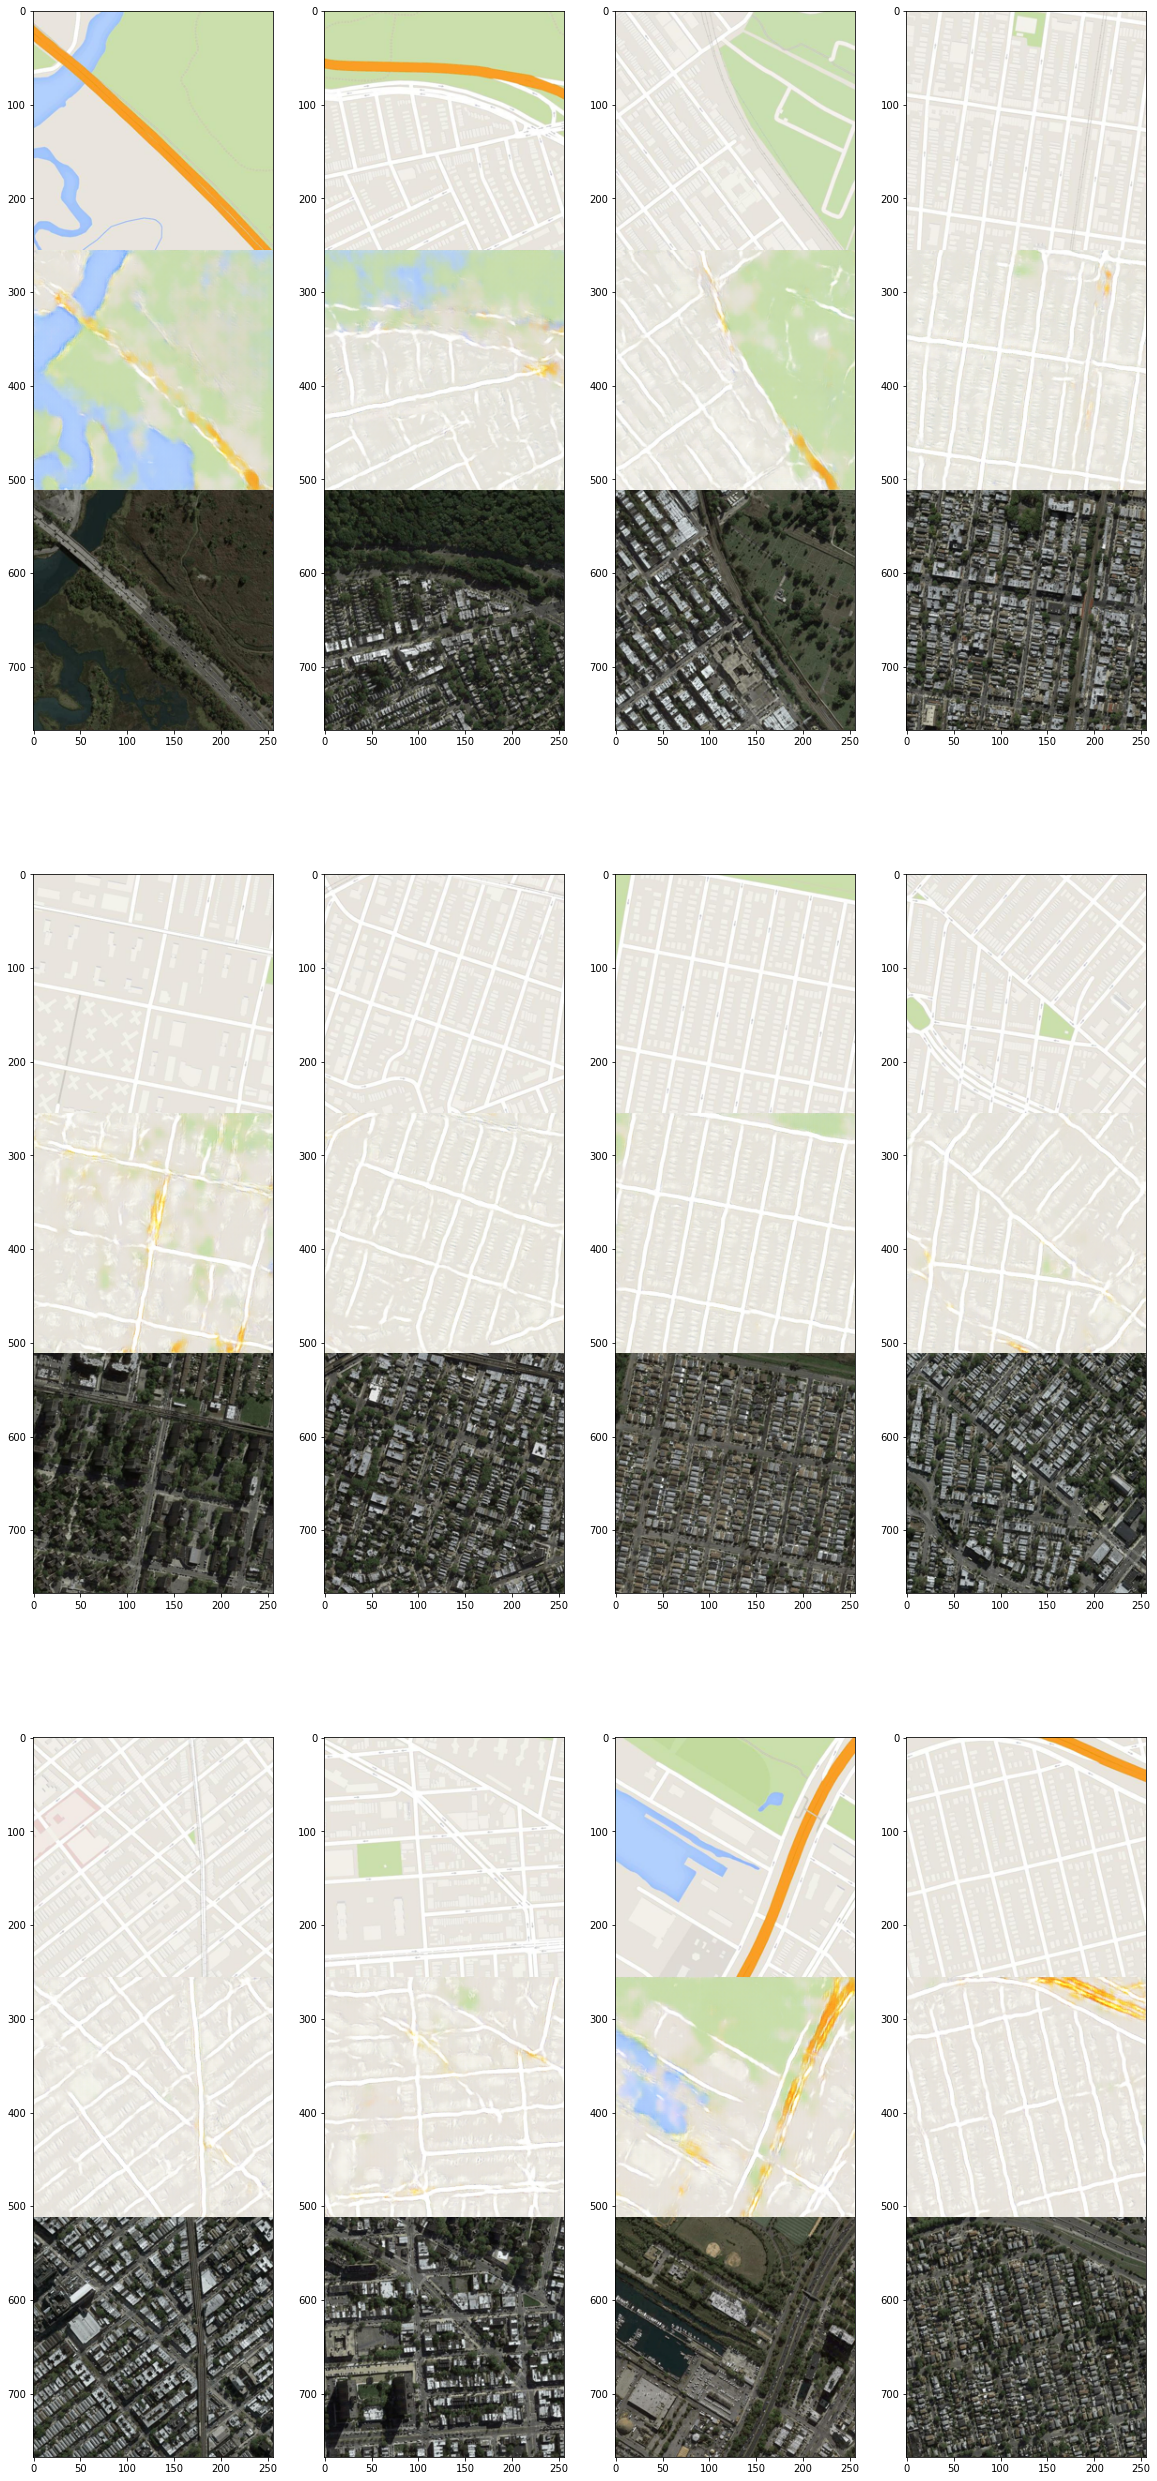

In [159]:
#------------------------------------------------------
# display 12 (3 batches of the best results you saved in the previous step)
#------------------------------------------------------
fig, axes = plt.subplots(3, 4, figsize=(20, 45))
idx = [75500, 76000, 76500]
images = []
for i in idx:
    for j in range(4):
        images.append(np.array(Image.open('generated_maps/map_iteration_%d_%d.png' % (i, j))))

for i in range(3):
    for j in range(4):
        axes[i, j].imshow(images[i*4 + j][::-1])